In [63]:
import importlib, data, LSTM_returns, optimization
import pandas as pd
import numpy as np
from LSTM_returns.CORE import *
from data.CORE import *

In [65]:
importlib.reload(data)


# Step 1: load each asset's df using data module
SOL_df = data.load_asset('SOLUSDT')        # Solana

Assets = pd.DataFrame(columns=['SOL'], index=['df', 'columns', 'LSTM'], dtype=object)
Assets.loc['df'] = [SOL_df]

In [66]:
importlib.reload(data)

# Step 2: pre-process each asset's df using the data module
Assets.loc['columns'] = [{} for _ in Assets.columns]
# Assets = Assets.astype(object)
for key in Assets.columns:
    df = Assets.loc['df', key].copy()
    print(f"{key} is available for range {data.get_min_max_time(df)}")

    df = data.subset(df, start=pd.Timestamp('2021-01-01 08:00:00'), end=pd.Timestamp('2026-01-01'))
    data.report_and_print_gaps(df)
    df = data.add_returns(df)
    df.dropna(inplace=True)

    df, Assets.at['columns', key] = data.normalize_data(df)
    df = data.train_test_split(df, split=0.8)
    Assets.at['df', key] = df

    print("\n")

SOL is available for range (Timestamp('2020-08-11 06:00:00'), Timestamp('2025-03-31 23:30:00'))
Gap of 0 days 01:30:00 		 from 2021-02-11 03:30:00 to 2021-02-11 05:00:00
Gap of 0 days 02:00:00 		 from 2021-03-06 01:30:00 to 2021-03-06 03:30:00
Gap of 0 days 03:00:00 		 from 2021-04-20 01:30:00 to 2021-04-20 04:30:00
Gap of 0 days 04:30:00 		 from 2021-04-25 04:00:00 to 2021-04-25 08:30:00
Gap of 0 days 05:00:00 		 from 2021-08-13 01:30:00 to 2021-08-13 06:30:00
Gap of 0 days 02:30:00 		 from 2021-09-29 06:30:00 to 2021-09-29 09:00:00
Gap of 0 days 01:30:00 		 from 2023-03-24 12:30:00 to 2023-03-24 14:00:00




In [ ]:
# Create an empty DataFrame with one column
df = pd.DataFrame(columns=['SOL', 'XLM'], dtype=object)

df.loc['row1'] = [{} for i in df.columns]

# Add a row with index 'row1' and set the 'SOL' column to a dictionary
df.at['row1', 'SOL'] = {'a': 1, 'b': 2}

df

# Add another row with a string
df.loc['row2', 'SOL'] = 'just a string'

# loc doesn't work
# df.loc['row3', 'SOL'] = {'x': 10, 'y': 20}

In [55]:
[df.shape for df in Assets.loc['df']]

[(74397, 12)]

In [76]:
importlib.reload(LSTM_returns)

# Step 3: create and train LSTMs using various hyperparameters using the LSTM_returns module
Assets.loc['LSTM'] = [{} for _ in Assets.columns]
Assets.loc['train_X_y'] = [{} for _ in Assets.columns]
for key, df in zip( Assets.columns, Assets.loc['df'] ):
    print(f"TRAINING {key}")

    features = df.columns
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume']
    target = "Return"

    print("vectorizing data")

    train_X_y = LSTM_returns.vectorize_train_data(df, target=target, features=features, episode_length=5)
    Assets.at['train_X_y', key] = train_X_y

    print("creating model")

    hyperparams = {
        'input_shape': train_X_y['train_X'].shape[1:],
        'epochs': 1
    }

    LSTM = LSTM_returns.create(hyperparams)

    LSTM_returns.train(LSTM, hyperparams, train_X_y)

    Assets.at['LSTM', key] = LSTM

TRAINING SOL
vectorizing data
creating model


C:\Users\Ian Chen-Adamczyk\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1860/1860 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0434 - mae: 0.0833
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


In [89]:
importlib.reload(LSTM_returns)

test_df = pd.DataFrame(columns=['x', 'y', 'target'])
test_df['x'] = range(0, 100)
test_df['y'] = range(0, 200, 2)
test_df['target'] = test_df['x'] + test_df['y']

test_df = data.train_test_split(test_df)
display(test_df.iloc[75:85])

train_X_y = LSTM_returns.vectorize_train_data(test_df, target='target', features=['x', 'y'], episode_length=4)
print(train_X_y)

,x,y,target,SPLIT
75,75,150,225,train
76,76,152,228,train
77,77,154,231,train
78,78,156,234,train
79,79,158,237,train
80,80,160,240,test
81,81,162,243,test
82,82,164,246,test
83,83,166,249,test
84,84,168,252,test


{'train_X': array([[[  0,   0],
        [  1,   2],
        [  2,   4],
        [  3,   6]],

       [[  1,   2],
        [  2,   4],
        [  3,   6],
        [  4,   8]],

       [[  2,   4],
        [  3,   6],
        [  4,   8],
        [  5,  10]],

       [[  3,   6],
        [  4,   8],
        [  5,  10],
        [  6,  12]],

       [[  4,   8],
        [  5,  10],
        [  6,  12],
        [  7,  14]],

       [[  5,  10],
        [  6,  12],
        [  7,  14],
        [  8,  16]],

       [[  6,  12],
        [  7,  14],
        [  8,  16],
        [  9,  18]],

       [[  7,  14],
        [  8,  16],
        [  9,  18],
        [ 10,  20]],

       [[  8,  16],
        [  9,  18],
        [ 10,  20],
        [ 11,  22]],

       [[  9,  18],
        [ 10,  20],
        [ 11,  22],
        [ 12,  24]],

       [[ 10,  20],
        [ 11,  22],
        [ 12,  24],
        [ 13,  26]],

       [[ 11,  22],
        [ 12,  24],
        [ 13,  26],
        [ 14,  28]],

    

465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


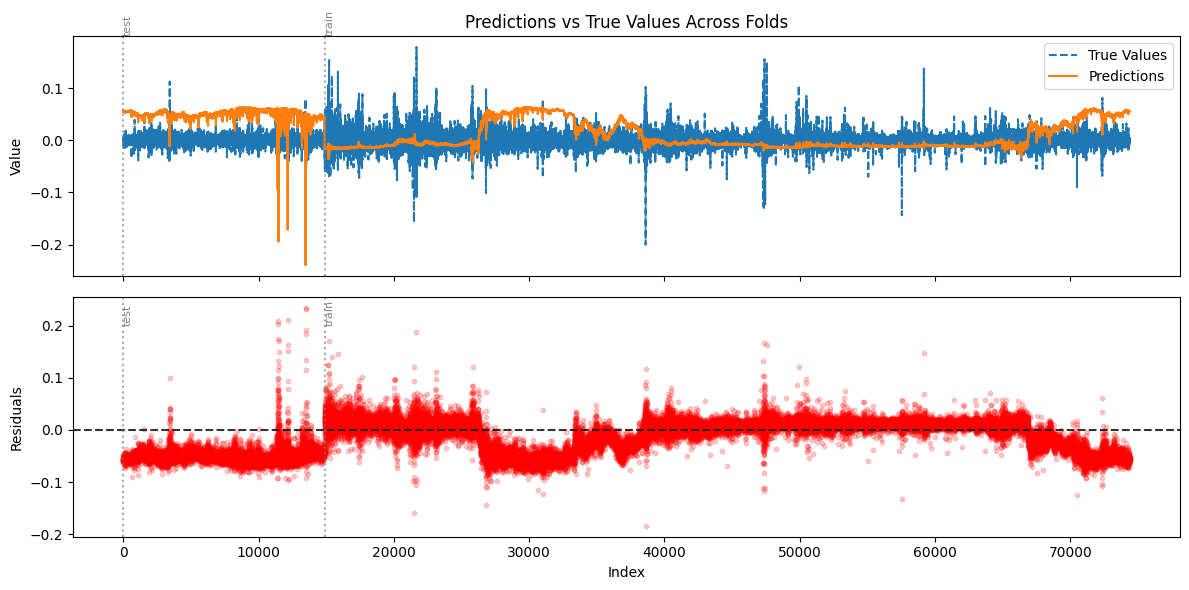

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\miniforge3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [80]:
importlib.reload(LSTM_returns)
LSTM_returns.all_folds_plot(Assets.at['LSTM', 'SOL'], Assets.at['train_X_y', 'SOL'])

In [75]:
[(key, value.shape) for key, value in Assets.at['train_X_y', 'SOL'].items() ]
Assets.at['train_X_y', 'SOL']['train_X'][0]

array([[[1.39847004e-04, 1.34579211e-04, 0.00000000e+00, 5.35217853e-05,
         1.55104239e-02, 1.58549620e-04, 9.97512506e-04, 8.68957975e-03,
         9.94778731e-05],
        [5.52481991e-05, 1.31860439e-04, 8.08635098e-05, 9.21955914e-05,
         4.34090769e-03, 4.47236899e-05, 4.64178613e-04, 3.05752106e-03,
         3.51990350e-05],
        [1.01173265e-04, 1.36618290e-04, 2.49622139e-05, 3.10771656e-06,
         1.63474647e-02, 1.66785240e-04, 8.83301515e-04, 1.50742050e-02,
         1.72361078e-04],
        [4.83421742e-06, 0.00000000e+00, 1.26568972e-05, 0.00000000e+00,
         4.50886224e-03, 4.56191971e-05, 3.86640877e-04, 5.76185689e-03,
         6.52765698e-05],
        [0.00000000e+00, 1.85216338e-04, 2.03916677e-05, 1.78866353e-04,
         3.27364687e-02, 3.37083995e-04, 1.39463145e-03, 3.32868592e-02,
         3.83927231e-04]]])

In [12]:
pred_r_s = LSTMs["SOL"].predict(train_X_y_s["SOL"]['test_X'])
pred_r_s

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.06717142],
       [0.06695232],
       [0.06610474],
       ...,
       [0.05019912],
       [0.05161503],
       [0.05117384]], dtype=float32)

NameError: name 'pred_r_s' is not defined

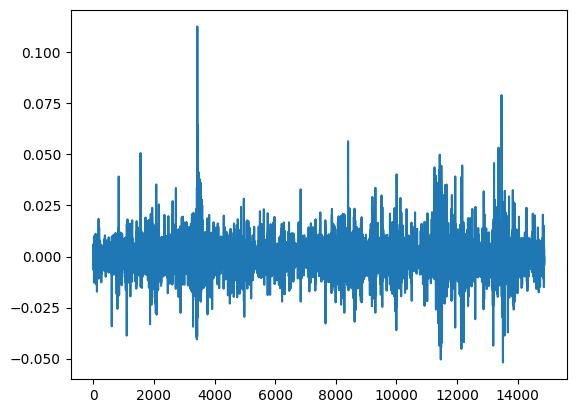

In [77]:
import matplotlib.pyplot as plt

look_at = 'SOL'
dummy_times = range(len(train_X_y_s[look_at]['test_y']))
plt.plot(dummy_times, train_X_y_s[look_at]['test_y'], label='test')
plt.plot(dummy_times, pred_r_s, label=look_at)
plt.legend()
plt.show()

In [9]:
SOL_df["Re"]

KeyError: 'Re'

In [ ]:
LSTMs["SOL"].predict(train_X_y_s["SOL"]['test_X'])

train_X_y_s["SOL"]['test_X']

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[[0.57438169, 0.56686565, 0.58450219, ..., 0.00793085,
         0.0101848 , 0.01229493],
        [0.57586648, 0.56781722, 0.58580304, ..., 0.00844323,
         0.01261371, 0.01525951],
        [0.57586648, 0.56693362, 0.58411545, ..., 0.00662633,
         0.00583074, 0.00703424],
        [0.5738292 , 0.56571017, 0.58348261, ..., 0.00624074,
         0.00827455, 0.0099724 ],
        [0.57324219, 0.56621994, 0.58351777, ..., 0.00551147,
         0.00556689, 0.00671101]],

       [[0.57586648, 0.56781722, 0.58580304, ..., 0.00844323,
         0.01261371, 0.01525951],
        [0.57586648, 0.56693362, 0.58411545, ..., 0.00662633,
         0.00583074, 0.00703424],
        [0.5738292 , 0.56571017, 0.58348261, ..., 0.00624074,
         0.00827455, 0.0099724 ],
        [0.57324219, 0.56621994, 0.58351777, ..., 0.00551147,
         0.00556689, 0.00671101],
        [0.57407092, 0.56499649, 0.58098639, ..., 0.00964507,
         0.01201455, 0.01442283]],

       [[0.57586648, 0.56693362, 0.5

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('expt-2-model-store', exist_ok=True)

# Save each LSTM model to a separate file
for key, model in LSTMs.items():
    model_path = f'expt-2-model-store/{key}.keras'
    model.save(model_path)
    print(f"Saved {key} model to {model_path}")


Saved SOL model to expt-2-model-store/SOL.keras


In [ ]:
dfs.__delitem__('MATIC')
LSTMs.__delitem__('MATIC')
train_X_y_s.__delitem__('MATIC')

KeyError: 'MATIC'

In [ ]:
# Step 5: get LSTM predictions
pre_s = {}
for key in LSTMs.keys():
    pre_s[key] = LSTMs[key].predict(train_X_y_s[key]['test_X'])

T = len(pre_s[key])
pred_r_s = {key: value.flatten() for key, value in pre_s.items()}

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
import numpy as np
importlib.reload(optimization)


# 3) Build the full (T,3) mu_preds array:
#    [ r_xlm(t), r_btc(t), 0.0 ]
mu_preds = np.vstack([
    *pred_r_s.values(),
    np.zeros(T)                # stable asset return is always zero
]).T                            # now shape (T,3)

# 4) Set up the loop
n = len(pred_r_s.values()) + 1
w_prev  = np.ones(n) / n         # e.g. start [1/3,1/3,1/3]
weights = np.zeros((T, n))

for t in range(T):
    mu_t  = mu_preds[t]          # shape (3,)
    w_new = optimization.max_return_with_turnover(
                mu=mu_t,
                w_prev=w_prev,
                turnover_penalty=10.0,  # tune to your strategy
                long_only=True
            )
    weights[t] = w_new
    w_prev    = w_new

: 

In [ ]:
import matplotlib.pyplot as plt

# dates = T = len(r_xlm)   # your test‐set timestamps, length T
df_w  = pd.DataFrame(
    weights,
    # dates,
    columns=[*[f"{tick}_weight" for tick in dfs.keys()], "Stable_weight"]
)

dummy_times = range(0, len(df_w))

plt.figure()
for col in df_w.columns:
    plt.plot(dummy_times, df_w[col], label=col)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Portfolio Weights Over Time')
plt.show()


NameError: name 'weights' is not defined

In [ ]:
look_at = 'SOL'
plt.plot(dummy_times, train_X_y_s[look_at]['test_y'], label='test')
plt.plot(dummy_times, pred_r_s[look_at], label=look_at)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

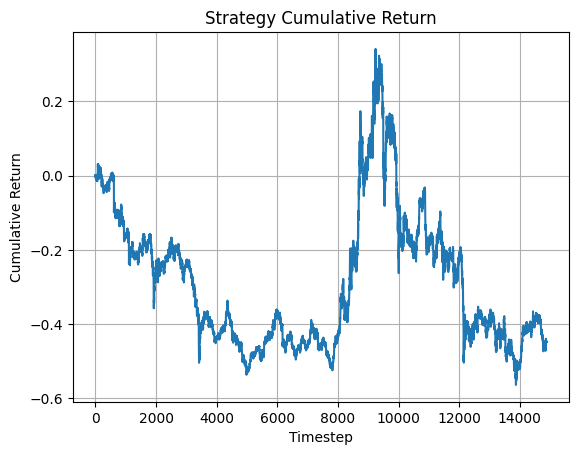

In [ ]:
rets = {key: dfs[key].loc[train_X_y_s[key]['test_index']]["Return"] for key in dfs.keys()}
ret_stable = np.zeros_like(rets["BTC"])
realized_rets = np.vstack([*rets.values(), ret_stable]).T     

port_rets = (weights * realized_rets).sum(axis=1)
cum_rets = np.cumprod(1 + port_rets) - 1
plt.plot(cum_rets)
plt.xlabel('Timestep')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Return')
plt.grid(True)
plt.show()

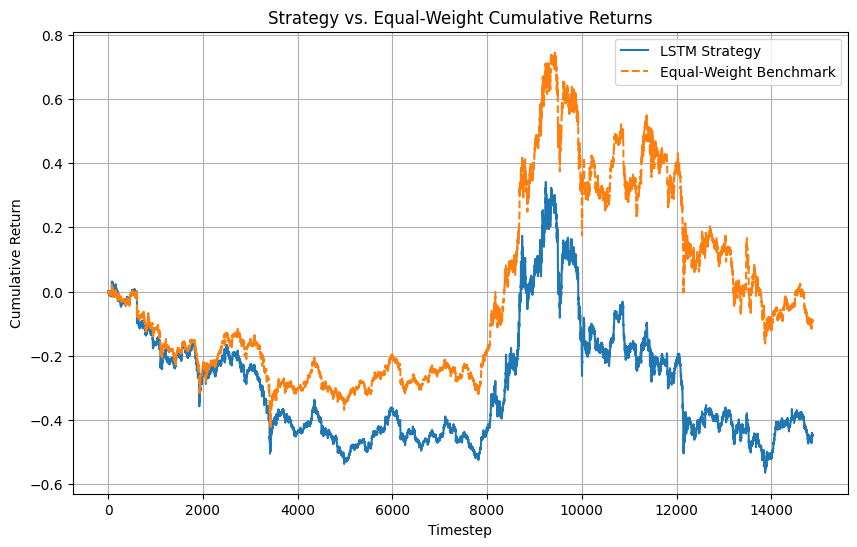

In [ ]:
port_rets   = (weights * realized_rets).sum(axis=1)        # (T,)
cum_rets    = np.cumprod(1 + port_rets) - 1               # (T,)

# 2) equal‑weight benchmark
n_assets    = weights.shape[1]
equal_w     = np.ones(n_assets) / n_assets                # (n_assets,)
eq_rets     = realized_rets.dot(equal_w)                  # (T,)
cum_eq_rets = np.cumprod(1 + eq_rets) - 1                 # (T,)

# 3) plot both
plt.figure(figsize=(10,6))
plt.plot(cum_rets,    label='LSTM Strategy')
plt.plot(cum_eq_rets, label='Equal‑Weight Benchmark', linestyle='--')
plt.xlabel('Timestep')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs. Equal‑Weight Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 6: compare to a buy-and-hold benchmark using PyPortfolioOpt to get returns at each step.

import numpy as np
import pandas as pd
from pypfopt.expected_returns     import mean_historical_return
from pypfopt.risk_models          import sample_cov, CovarianceShrinkage
from pypfopt.efficient_frontier    import EfficientFrontier


train_idx = list(train_X_y_s.values())[0]['train_index']
raw_dfs = {key: data.load_asset(key) for key in dfs.keys()}
prices = {key: df.loc[train_idx, "Close"].rename(key) for key, df in raw_dfs.items()}


# 1) Build & clean your 2‑asset price DataFrame
prices_risky = pd.concat(prices.items(), axis=1)
prices_risky = (
    prices_risky
    .apply(pd.to_numeric, errors="coerce")  # force floats, NaN out non‑numeric
    .replace([0, np.inf, -np.inf], np.nan)
    .dropna()
)

# 2) Annualize at 30‑min (48×365)
freq = 48 * 365

# 3) Compute expected returns
mu_r = mean_historical_return(prices_risky, frequency=freq)

# 4A) OPTION A: Ledoit‑Wolf shrinkage (recommended)
cs       = CovarianceShrinkage(prices_risky, frequency=freq)
Sigma_r  = cs.ledoit_wolf()

# 4B) OPTION B: add a tiny diagonal jitter to your sample covariance
# Sigma_r = sample_cov(prices_risky, frequency=freq)
# Sigma_r += 1e-4 * np.eye(Sigma_r.shape[0])

# 5) Solve for the max‑Sharpe (risky) weights
ef       = EfficientFrontier(mu_r, Sigma_r, weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=0.0)   # cash return = 0
w_risky  = ef.clean_weights()       # e.g. {'XLM':0.3,'BTC':0.6}

# 6) Allocate the remainder to cash
w_risky['Stable'] = 1 - sum(w_risky.values())

print("Max‑Sharpe w/ cash:", w_risky)



KeyError: "None of [DatetimeIndex(['2021-01-01 10:00:00', '2021-01-01 10:30:00',\n               '2021-01-01 11:00:00', '2021-01-01 11:30:00',\n               '2021-01-01 12:00:00', '2021-01-01 12:30:00',\n               '2021-01-01 13:00:00', '2021-01-01 13:30:00',\n               '2021-01-01 14:00:00', '2021-01-01 14:30:00',\n               ...\n               '2024-05-25 18:00:00', '2024-05-25 18:30:00',\n               '2024-05-25 19:00:00', '2024-05-25 19:30:00',\n               '2024-05-25 20:00:00', '2024-05-25 20:30:00',\n               '2024-05-25 21:00:00', '2024-05-25 21:30:00',\n               '2024-05-25 22:00:00', '2024-05-25 22:30:00'],\n              dtype='datetime64[ns]', name='Open time', length=59513, freq=None)] are in the [index]"

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# assume you already have:
#   mu_r   → pd.Series of expected returns for ['XLM','BTC']
#   Sigma_r → pd.DataFrame covariance matrix for ['XLM','BTC']

# 1) Inspect μ
print("Estimated expected returns:")
print(mu_r)

# 2) Compute an adjusted RF just below the minimum μ
min_mu = mu_r.min()
rf_adj = min_mu - 1e-6
print(f"Adjusting risk-free rate to {rf_adj:.6f}")

# 3) Solve max‑Sharpe with the adjusted RF
ef = EfficientFrontier(mu_r, Sigma_r, weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=rf_adj)
w_risky = ef.clean_weights()

# 4) Allocate remainder to cash
w_risky['Stable'] = 1 - sum(w_risky.values())

print("Max‑Sharpe w/ adjusted RF:", w_risky)


print(prices_risky)


Estimated expected returns:
XLM   -0.515079
BTC   -0.505002
dtype: float64
Adjusting risk-free rate to -0.515080
Max‑Sharpe w/ adjusted RF: OrderedDict({'XLM': 0.0, 'BTC': 1.0, 'Stable': 0.0})
